# **Tugas Deep Learning - Nomor 2B**

Nama: Pieter Christy Yan Yudhistira

NIM: 23510201111068

Kelas: DL-C

## Tugas

2. Fine-tune AlexNet to achieve at least 80% test accuracy on the MNIST dataset. Your network should train under 10 minutes, without GPUs.


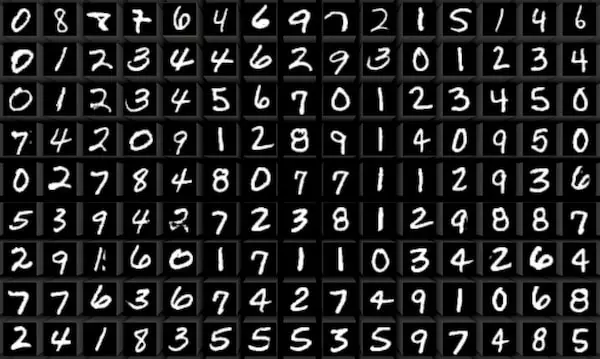

MNIST Digit merupakan kumpulan data yang terdiri dari handwritten digit atau digit yang ditulis tangan. Total data keseluruhan terdiri dari 70.000 gambar, dimana 60.000 gambar data pelatihan dan 10.000 gambar data pengujian.

In [1]:
!wget https://github.com/phoebetronic/mnist/raw/main/mnist_train.csv.zip
!wget https://github.com/phoebetronic/mnist/raw/main/mnist_test.csv.zip
!unzip mnist_train.csv.zip
!unzip mnist_test.csv.zip


--2025-09-11 10:28:33--  https://github.com/phoebetronic/mnist/raw/main/mnist_train.csv.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/phoebetronic/mnist/main/mnist_train.csv.zip [following]
--2025-09-11 10:28:33--  https://raw.githubusercontent.com/phoebetronic/mnist/main/mnist_train.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13270831 (13M) [application/zip]
Saving to: ‘mnist_train.csv.zip’

mnist_train.csv.zip 100%[===================>]  12.66M  --.-KB/s    in 0.07s   

2025-09-11 10:28:34 (182 MB/s) - ‘mnist_train.csv.zip’ saved [13270831/13270831]

--2025-09-11 10:28:34--  

Dalam tugas ini, saya bertujuan untuk melakukan fine tuning AlexNet model untuk mencapai akurasi minimal 80% akurasi test dalam data MNIST sesuai dengan intruksi yang diberikan diantara itu:

- Fine-tuning AlexNet dengan dataset MNIST untuk prediksi digit
- Model mampu belajar dibawah 10 menit tanpa menggunakan GPUs.

# Code


## Import Libraries

In [2]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms

# Library untuk mendapatkan ringkasan informasi tentang model (Terutama parameter)
from torchsummary import summary

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

## Load Data

In [3]:
# Define column names
col_names = ['label'] + [f'pixel{i}' for i in range(784)]

# Load the training and test datasets without a header, assigning column names
train = pd.read_csv("/content/mnist_train.csv", header=None, names=col_names)
test = pd.read_csv("/content/mnist_test.csv", header=None, names=col_names)

## MNIST Overview

MNIST Digit yang saya gunakan adalah versi CSV, dimana terdiri dari label dan pixel 0 - 783 untuk merepresentasikan pixel gambar.

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Bisa disimpulkan gambar dalam MNIST digit terdiri dari 60.000 data pelatihan dan 10.000 data pengujian, dengan masing-masing gambar terdiri dari 784 (-1 kolom untuk label) pixel.

In [7]:
print(f"Train data: {train.shape}")
print(f"Test data: {test.shape}")
print(f"Labels: {test['label'].unique()}")

Train data: (60000, 785)
Test data: (10000, 785)
Labels: [7 2 1 0 4 9 5 6 3 8]


In [8]:
train['label'].value_counts().sort_index()

,count
label,
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851


Berdasarkan persebaran data, kita dapat menyimpulkan data pelatihan seimbang (masing-masing nilai di range 5400 - 6700)

# Exploratory Data Analysis (EDA)

## Ilustrasi MNIST Digit

/tmp/ipython-input-2180870905.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(row[0])


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

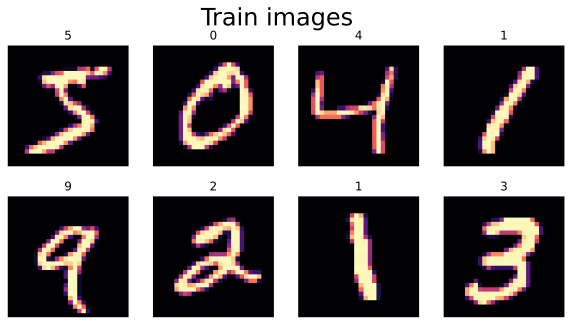

In [9]:
# Menampilkan MNIST Digit pelatihan
fig, ax = plt.subplots(figsize=(10, 5))
for ind, row in train.iloc[:8, :].iterrows():
    plt.subplot(2, 4, ind+1)
    plt.title(row[0])
    img = row.to_numpy()[1:].reshape(28, 28)
    fig.suptitle('Train images', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='magma')
ax.axis('off')

/tmp/ipython-input-2041173255.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(row[0])


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

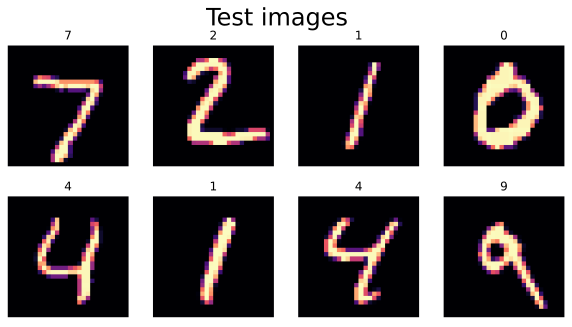

In [10]:
# Menampilkan MNIST Digit pengujian
fig, ax = plt.subplots(figsize=(10, 5))
for ind, row in test.iloc[:8, :].iterrows():
    plt.subplot(2, 4, ind+1)
    plt.title(row[0])
    img = row.to_numpy()[1:].reshape(28, 28)
    fig.suptitle('Test images', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='magma')
ax.axis('off')

# Load & Preprocessing Tensor Dataset

Kode ini saya gunakan untuk mengolah data MNIST yang direpresentasikan dalam .csv menjadi data tensor

In [16]:
# Custom dataset for MNIST CSV
class MNIST_CSV_Dataset(Dataset):
    def __init__(self, data, transform=None, limit=10000):
        self.labels = data.iloc[:limit, 0].values
        self.images = data.iloc[:limit, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Preprocessing

Dalam preprocessing ini, saya menggunakan Resize untuk mengubah ukuran gambar, greyScale dan Normalisasi.

Untuk bagian resize, saya menggunakan resize 224x224 karena itu merupakan input size yang digunakan oleh model AlexNet dan saya tidak berencana untuk mengubahnya. Meskipun itu tidak cocok dengan data MNIST, namun saya berencana tetap ukuran sesuai dengan model AlexNet

"Sometimes you can get away with using different input sizes (if there is no conflict in tensor dimensions), but it is recommended to use the original input size the network was designed for (I think ResNet and AlexNet are 224x224 while Inception is 299x299)."

Untuk bagian greyscale, hal ini untuk menyesuaikan dataset MNIST dengan model AlexNet, kenapa? karena AlexNet belajar menggunakan dataset RGB dan MNIST memiliki struktur (28, 28), menandakan dataset greyscale. Maka dengan channel=3 membuat gambar menjadi RGB compatible

Kemudian saya menggunakan transforms.Normalize((0.1307,), (0.3081,)) sebagai Normalize dimana menggunakan modifikasi mean 0.1307 dan standar deviasi dikarenakan saya menemukan bahwa data MNIST memiliki distribusi yang unik sehingga lebih cocok menggunakan normalisasi tersebut.

Referensi:
- https://github.com/pytorch/examples/issues/653
- https://discuss.pytorch.org/t/transfer-learning-grayscale-image-size-and-activation-function/9953/4
- https://medium.com/@akshat117/mnist-with-lenet5-alexnet-and-vgg16-beginners-guide-f63e26f2d3e6

Berikut ini merupakan contoh dari `Grayscale()` sebagai augmentasi data greyscale into RGB

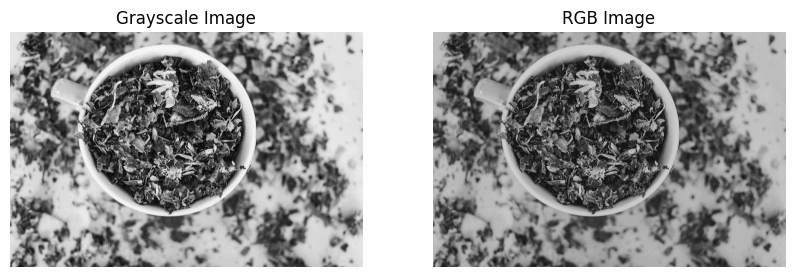

In [17]:
# Preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)), # AlexNet preferred size
    transforms.Grayscale(num_output_channels=3),  # convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [26]:
train_dataset = MNIST_CSV_Dataset(train, transform=transform, limit=3000)
test_dataset = MNIST_CSV_Dataset(test, transform=transform, limit=300)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# AlexNet Model

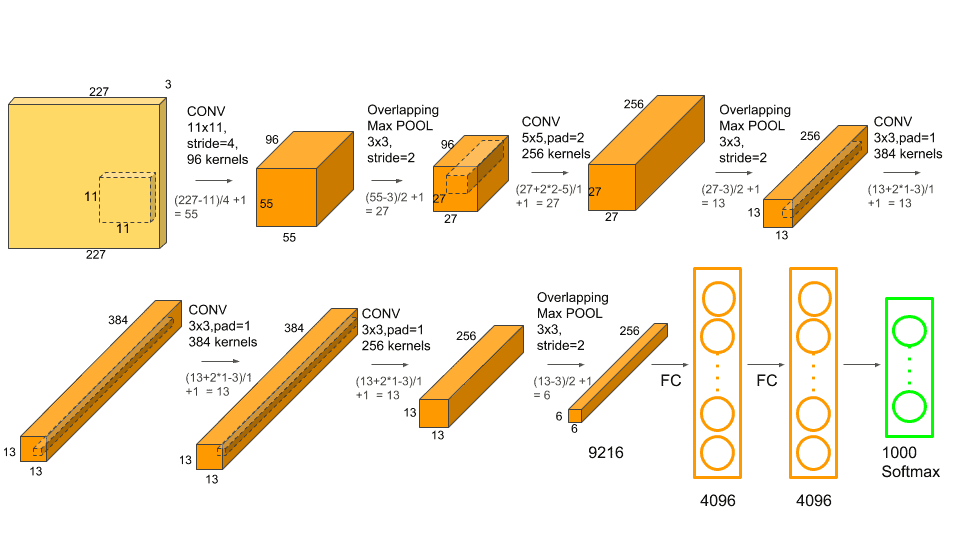

Dalam tugas ini, saya menggunakan model AlexNet yang tersedia dari library torchvision untuk membantu saya tidak perlu mendeklarasi model secara manual. AlexNet disini juga saya dapat eksperimen menggunakan model AlexNet yang memiliki weight pretrained.

In [27]:
from torchvision.models import alexnet

model = alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 10)  # change last FC layer

device = torch.device("cpu")
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
summary(model, (3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

# Pelatihan (Training)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses = [], []
trainAcc, testAcc = [], []
EPOCH = 2

In [30]:
# Training loop
for epoch in range(EPOCH):  # should converge quickly
    model.train()
    train_loss = 0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / total_train
    train_accuracy = 100 * correct_train / total_train

    # Evaluation
    model.eval()
    test_loss = 0
    correct_test, total_test = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            test_loss += loss.item() * labels.size(0)

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test

    # Accuracy Metric
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    trainAcc.append(train_accuracy)
    testAcc.append(test_accuracy)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.2f}%, "
          f"Test Loss={avg_test_loss:.4f}, Test Acc={test_accuracy:.2f}%, "
          f"Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Train Loss=1.5897, Train Acc=47.10%, Test Loss=0.9377, Test Acc=84.33%, Precision=0.77, Recall=0.82, F1=0.78
Epoch 2: Train Loss=0.5977, Train Acc=81.07%, Test Loss=0.3923, Test Acc=89.67%, Precision=0.90, Recall=0.89, F1=0.89


# Evalution

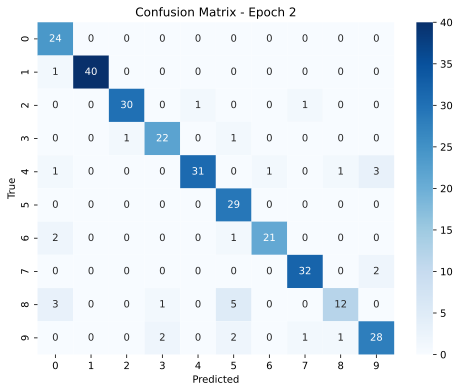

In [31]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title(f"Confusion Matrix - Epoch {epoch+1}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

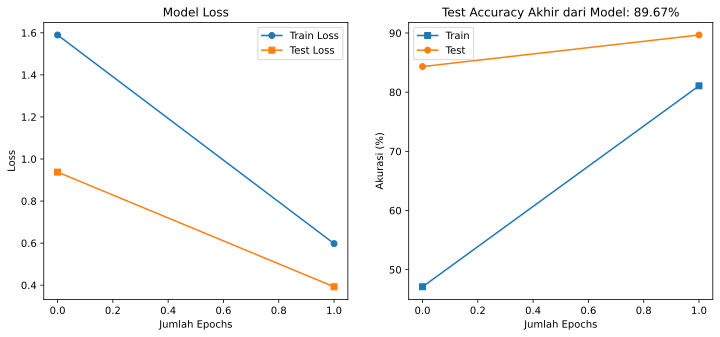

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(train_losses, 'o-', label='Train Loss')
ax[0].plot(test_losses, 's-', label='Test Loss')
ax[0].set_xlabel('Jumlah Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Jumlah Epochs')
ax[1].set_ylabel('Akurasi (%)')
ax[1].set_title(f'Test Accuracy Akhir dari Model: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()